In [24]:
import pandas as pd
import plotly.express as px

In [25]:
px.set_mapbox_access_token(open(".mapbox_token").read())

Data from https://donnees.montreal.ca/ville-de-montreal/resultats-detailles

In [26]:
df = pd.read_csv("data.csv")
df.head()

/Users/nicolas/opt/miniconda3/envs/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,DistrictID,District,Bureau,Poste,Candidat,Parti,Votes,TotalValidVotes,TotalRejectedVotes,TotalVotes,DerniereModification
0,171,171-Champlain—L'Île-des-Soeurs,923,0.0,THIBODEAU Gilbert,Action Montréal - Équipe Gilbert Thibodeau,2,293,5,298,2021-11-08 08:29:41
1,171,171-Champlain—L'Île-des-Soeurs,923,0.0,CODERRE Denis,Ensemble Montréal - Équipe Denis Coderre,82,293,5,298,2021-11-08 08:29:41
2,171,171-Champlain—L'Île-des-Soeurs,923,0.0,BERNARDO Beverly,Indépendant,1,293,5,298,2021-11-08 08:29:41
3,171,171-Champlain—L'Île-des-Soeurs,923,0.0,DUVAL Jean,Indépendant,0,293,5,298,2021-11-08 08:29:41
4,171,171-Champlain—L'Île-des-Soeurs,923,0.0,HU Fang,Indépendant,0,293,5,298,2021-11-08 08:29:41


In [27]:
df["NOM_SECTION"] = df.apply(lambda row: str(row["DistrictID"]).zfill(3) +"-"+ str(row["Bureau"]).replace("a","").replace("b","").zfill(3), axis=1)


In [28]:
c = ["CODERRE Denis", "PLANTE Valérie", "HOLNESS Balarama"]
df2 = (df.query("Candidat in @c and Poste==0")[["NOM_SECTION", "Candidat", "Votes"]]
       .pivot_table(index="NOM_SECTION", columns="Candidat", values="Votes", aggfunc=sum)
      .reset_index()
      .rename({c[0]: "Denis Coderre", c[1]: "Valérie Plante", c[2]: "Balarama Holness"}, axis=1))

def winner(row):
    if row["Valérie Plante"] > row["Denis Coderre"] and row["Valérie Plante"] > row["Balarama Holness"]:
        return "Valérie Plante"
    if row["Balarama Holness"] > row["Denis Coderre"] and row["Balarama Holness"] > row["Valérie Plante"]:
        return "Balarama Holness"
    if row["Denis Coderre"] > row["Balarama Holness"] and row["Denis Coderre"] > row["Valérie Plante"]:
        return "Denis Coderre"
    return "ex aequo"
            
df2["Winner"] = df2.apply(winner, axis=1)
df2.head()

Candidat,NOM_SECTION,Denis Coderre,Balarama Holness,Valérie Plante,Winner
0,011-001,33,2,66,Valérie Plante
1,011-002,35,2,61,Valérie Plante
2,011-003,52,5,60,Valérie Plante
3,011-004,50,1,45,Denis Coderre
4,011-005,35,5,76,Valérie Plante


GeoJSON file from https://donnees.montreal.ca/ville-de-montreal/sections-de-vote and simplified via https://mapshaper.org/ to reduce size to 15%.

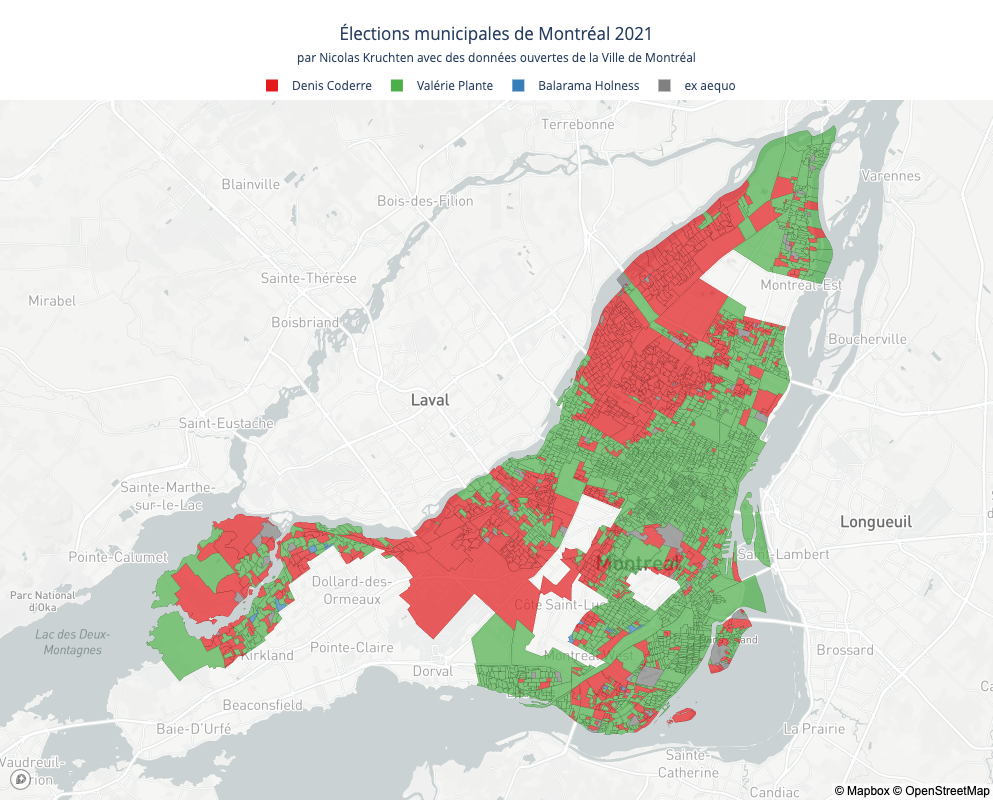

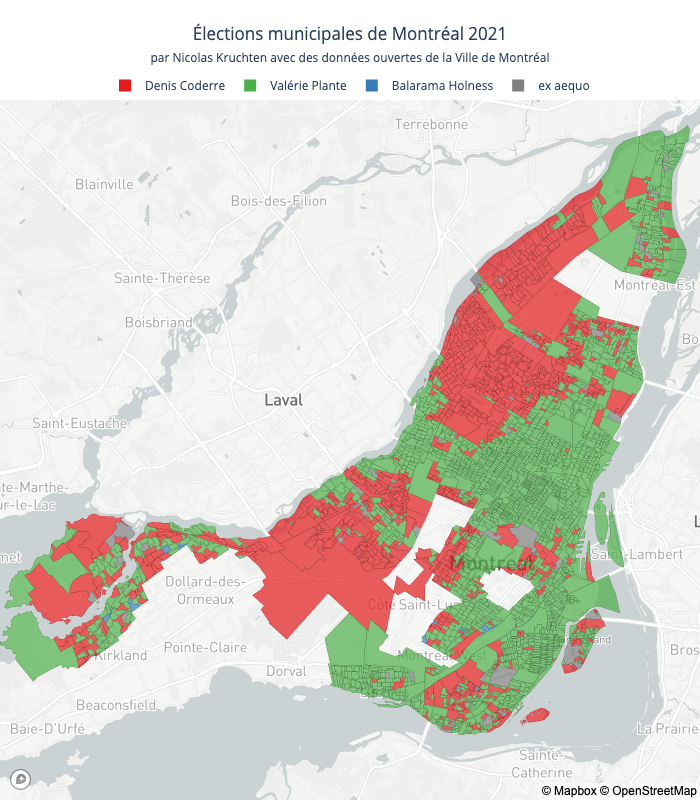

In [29]:
geojson_url="https://gist.githubusercontent.com/nicolaskruchten/c3cf6b7563631fb97b735bf8c07c9713/raw/c90edcc939db1c1aee0163343bbd63a0b650eccc/section-vote-2021-simple.json"
fig = px.choropleth_mapbox(df2, geojson=geojson_url, color="Winner",
                           locations="NOM_SECTION", featureidkey="properties.NOM_SECTION",
                           center={"lat": 45.5517, "lon": -73.7073},
                           color_discrete_map={
                               "Denis Coderre":"#e41a1c", 
                               "Valérie Plante":"#4daf4a",
                               "Balarama Holness": "#377eb8",
                               "ex aequo": "grey",
                           },
                           hover_name="NOM_SECTION",
                           hover_data={"Winner": False, "NOM_SECTION": False,
                                       "Valérie Plante": True, 
                                       "Denis Coderre": True, 
                                       "Balarama Holness": True, 
                                      },
                           category_orders=dict(Winner=[
                               "Denis Coderre", 
                               "Valérie Plante",
                               "Balarama Holness",
                               "ex aequo",
                           ]),
                           mapbox_style="light", zoom=10, height=800, opacity=0.7)
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0}, 
                  legend=dict(orientation="h", y=1, yanchor='bottom', x=0.5, xanchor="center", title=""),
                 title=dict(y=0.95, yanchor='top',text='Élections municipales de Montréal 2021'
                            '<br><span style="font-size:12px">'
                            'par <a href="https://nicolas.kruchten.com/">Nicolas Kruchten</a> '
                            'avec des <a href="https://donnees.montreal.ca/ville-de-montreal/">données ouvertes de la Ville de Montréal</a>'
                            '</span>', x=0.5))
fig.update_traces(marker_line_width=0.1, below='')
fig.show()
fig.show("png")

In [30]:
fig.write_html("index.html", include_plotlyjs="cdn")